<a href="https://colab.research.google.com/github/vikyap/Journal-Abstract-Sentence-Classification/blob/main/Journal_abstract_sentence_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import tensorflow as tf
import tensorflow_hub as hub 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import random
import string

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline 

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Explore & Preprocess data

In [22]:
data_dir = "drive/MyDrive/Abstract sentence classification/Data/"

In [23]:
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['drive/MyDrive/Abstract sentence classification/Data/dev.txt',
 'drive/MyDrive/Abstract sentence classification/Data/train.txt',
 'drive/MyDrive/Abstract sentence classification/Data/test.txt']

In [24]:
def get_lines(filename): 
  file = open(filename, "r")
  return file.readlines()

In [25]:
# view the dataset
train_lines = get_lines(data_dir + "train.txt")
train_lines[:30]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [26]:
# preprocess text data
def preprocess_text(filename): 
  input = get_lines(filename)
  output = []
  abstract_whole = ""

  for line in input: 
    if line.startswith("###"): # start of a new abstract
      abstract_id = line
      abstract_whole = ""
    elif line.isspace(): # end of an abstract
      abstract_lines = abstract_whole.splitlines()

      for index, abstract_line in enumerate(abstract_lines): 
        line_data = {}
        line_data["label"] = abstract_line.split("\t")[0] # what role that line is
        line_data["line"] = abstract_line.split("\t")[1].lower() 
        line_data["index"] = index # the index of the line within its abstract
        line_data["total_lines_in_abstract"] = len(abstract_lines) - 1
        output.append(line_data)
    
    else: 
      abstract_whole += line
    
  return output 

In [27]:
# preprocess for train, validation, and test sets
train_data = preprocess_text(data_dir + "train.txt")
val_data = preprocess_text(data_dir + "dev.txt")
test_data = preprocess_text(data_dir + "test.txt")

In [28]:
train_data[:20]

[{'index': 0,
  'label': 'OBJECTIVE',
  'line': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines_in_abstract': 11},
 {'index': 1,
  'label': 'METHODS',
  'line': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines_in_abstract': 11},
 {'index': 2,
  'label': 'METHODS',
  'line': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines_in_abstract': 11},
 {'index': 3,
  'label': 'METHODS',
  'line': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines_in_abstract': 11},
 {'index': 4,
  'label': 'METHODS',
  'line': 'secondary outcome mea

In [29]:
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)

In [30]:
train_df.head(20)

,label,line,index,total_lines_in_abstract
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


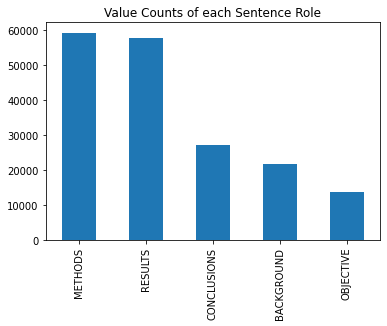

In [31]:
# distribution of labels 
train_df["label"].value_counts().plot.bar()
plt.title("Value Counts of each Sentence Role");

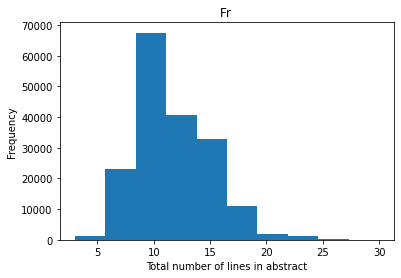

In [32]:
train_df["total_lines_in_abstract"].plot.hist()
plt.title("Fr ")
plt.xlabel("Total number of lines in abstract");

In [33]:
# convert text lines into lists
train_lines = train_df["line"].tolist()
val_lines = val_df["line"].tolist()
test_lines = test_df["line"].tolist()

In [34]:
train_lines[:20]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [35]:
# one hot encoded labels work better with categorical crossentropy 
one_hot = OneHotEncoder(sparse=False)

train_label_one_hot = one_hot.fit_transform(train_df["label"].to_numpy().reshape(-1, 1))
val_label_one_hot = one_hot.transform(val_df["label"].to_numpy().reshape(-1, 1))
test_label_one_hot = one_hot.transform(test_df["label"].to_numpy().reshape(-1, 1))

In [36]:
label_encoder = LabelEncoder() 

train_label_encode = label_encoder.fit_transform(train_df["label"].to_numpy())
val_label_encode = label_encoder.transform(val_df["label"].to_numpy())
test_label_encode = label_encoder.transform(test_df["label"].to_numpy())

In [37]:
# view what the encoded labels look like
print("One hot encoding:\n", train_label_one_hot)
print("\nLabel encoding:\n", train_label_encode)

One hot encoding:
 [[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]

Label encoding:
 [3 2 2 ... 4 1 1]


# Model_0 Baseline

In [38]:
# score the models based on accuracy, precision, recall, f1
def score(y_true, y_preds):
  accuracy = accuracy_score(y_true, y_preds) 
  precision, recall, f1, support = precision_recall_fscore_support(y_true, y_preds, average="weighted")
  score = {"accuracy": accuracy, 
           "precision": precision, 
           "recall": recall, 
           "f1": f1}
  return score

In [39]:
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), 
                     ("clf", MultinomialNB())
])

model_0.fit(X=train_lines, 
            y=train_label_encode)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [40]:
model_0.score(X=val_lines,
              y=val_label_encode)

0.7218323844829869

In [41]:
# baseline results
baseline_preds = model_0.predict(val_lines)
model_0_result = score(val_label_encode, baseline_preds)
model_0_result

{'accuracy': 0.7218323844829869,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

# Model_1 Conv1D with Token Embedding

In [42]:
# explore how long each line is on average
length_line = [len(line.split()) for line in train_lines]
average_length = np.mean(length_line)
average_length

26.338269273494777

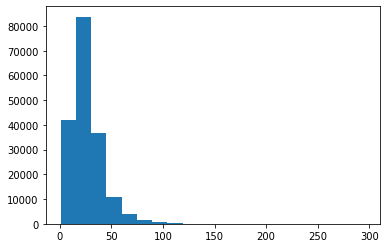

In [43]:
plt.hist(length_line, bins=20);

In [44]:
text_vectorizer = TextVectorization(max_tokens=68000, # number of words in vocabulary
                                    output_sequence_length=int(np.percentile(length_line, 95))) # length of line that covers 95% of data

In [45]:
text_vectorizer.adapt(train_lines)

In [46]:
# explore text vocabulary characteristics
text_vocab = text_vectorizer.get_vocabulary()
print(f"Total vocabulary: {len(text_vocab)}")
print(f"Most common words: {text_vocab[:5]}")
print(f"Least common words: {text_vocab[-5:]}")

Total vocabulary: 64841
Most common words: ['', '[UNK]', 'the', 'and', 'of']
Least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [47]:
token_embed = layers.Embedding(input_dim=len(text_vocab), 
                               output_dim=128, 
                               mask_zero=True, 
                               name="token_embedding")

In [48]:
# sample line to test vectorizer and embedding
random_line = random.choice(train_lines)
print(f"Line:\n {random_line}")
print(f"\nLength of line:\n {len(random_line.split())}")
vectorized_line = text_vectorizer([random_line])
print(f"\nAfter vectorization:\n {vectorized_line}")
embedded_line = token_embed(vectorized_line)
print(f"\nAfter embedding:\n {embedded_line}")
print(f"\nShape of line: {embedded_line.shape}")

Line:
 fibromyalgia patients .

Length of line:
 3

After vectorization:
 [[3987   12    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

After embedding:
 [[[ 0.03730107 -0.02031229  0.02848077 ...  0.04335574  0.00972165
   -0.00612609]
  [ 0.04964148 -0.04049734  0.03485424 ...  0.01675363  0.02750082
    0.02120557]
  [ 0.04259216 -0.03180423 -0.03113142 ... -0.02388157  0.0391424
    0.04517678]
  ...
  [ 0.04259216 -0.03180423 -0.03113142 ... -0.02388157  0.0391424
    0.04517678]
  [ 0.04259216 -0.03180423 -0.03113142 ... -0.02388157  0.0391424
    0.04517678]
  [ 0.04259216 -0.03180423 -0.03113142 ... -0.02388157  0.0391424
    0.04517678]]]

Shape of line: (1, 55, 128)


In [49]:
# create tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_lines, train_label_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_lines, val_label_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_lines, test_label_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [50]:
# create batches and prefetch to decrease training time 
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [51]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
line_vectors = text_vectorizer(inputs) # create vectorized lines
token_embeddings = token_embed(line_vectors) # create token embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name="Conv1D_token_embedding")

model_1.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [52]:
model_1.summary()

Model: "Conv1D_token_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)      

In [53]:
model_1_history = model_1.fit(train_dataset, 
                              steps_per_epoch=int(0.1*len(train_dataset)), # use 10% of training data for faster training
                              epochs=3, 
                              validation_data=val_dataset, 
                              validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 20s 17ms/step - loss: 0.9222 - accuracy: 0.6348 - val_loss: 0.6831 - val_accuracy: 0.7427
Epoch 2/3
562/562 [==============================] - 9s 15ms/step - loss: 0.6555 - accuracy: 0.7571 - val_loss: 0.6274 - val_accuracy: 0.7716
Epoch 3/3
562/562 [==============================] - 9s 15ms/step - loss: 0.6156 - accuracy: 0.7749 - val_loss: 0.5922 - val_accuracy: 0.7839


In [54]:
# evaluate on full validation dataset
model_1.evaluate(val_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5957 - accuracy: 0.7874


[0.5956764817237854, 0.7874354720115662]

In [55]:
# prediction probablities of each class label 
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

array([[4.0202335e-01, 1.5529813e-01, 8.7039389e-02, 3.1930539e-01,
        3.6333751e-02],
       [4.6847573e-01, 2.4363530e-01, 1.2473507e-02, 2.6821813e-01,
        7.1973070e-03],
       [1.6464174e-01, 6.3217944e-03, 1.6669637e-03, 8.2730728e-01,
        6.2193983e-05],
       ...,
       [4.4435455e-06, 5.2398822e-04, 6.2118302e-04, 3.1209374e-06,
        9.9884725e-01],
       [5.3342305e-02, 4.7706702e-01, 8.3062425e-02, 7.5795233e-02,
        3.1073296e-01],
       [1.6561438e-01, 6.7007786e-01, 5.4443348e-02, 3.7427243e-02,
        7.2437212e-02]], dtype=float32)

In [56]:
# convert to prediction of each class label 
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [57]:
# model_1 results
model_1_result = score(val_label_encode, model_1_preds)
model_1_result

{'accuracy': 0.7874354561101549,
 'f1': 0.784871100567116,
 'precision': 0.7838735901565689,
 'recall': 0.7874354561101549}

# Model_2 Universal Sentence Encoder (TensorFlow Hub)

In [58]:
# download pretrained model from tensorflow hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", 
                                        trainable=False, 
                                        name="universal_sentence_encoder")

In [59]:
# sample line to test embedding
print(f"Line:\n {random_line}")
print(f"\nAfter embedding:\n {tf_hub_embedding_layer([random_line])}")

Line:
 fibromyalgia patients .

After embedding:
 [[-2.60524619e-02 -4.28525247e-02  6.29879460e-02  5.93569502e-02
   5.90740070e-02  4.24016193e-02 -3.97311188e-02 -1.47258891e-02
  -1.41683770e-02 -1.07082515e-03  7.57827163e-02 -4.55350801e-03
   5.35512082e-02 -3.11087277e-02  4.14545909e-02 -2.49848552e-02
  -7.59159774e-02 -3.28955874e-02  1.05904900e-02 -1.74530614e-02
  -1.87391846e-03 -9.79181100e-03  7.33563453e-02 -5.45266941e-02
   5.56691848e-02  1.34137850e-02 -5.80500290e-02 -3.06463744e-02
   4.88694124e-02 -1.61213882e-03  1.05305780e-02  7.59179890e-02
  -3.11058084e-03 -6.95399269e-02  5.98325916e-02  6.08163998e-02
   9.12985671e-03  9.39039141e-03  3.35196704e-02 -2.69388873e-02
  -6.65149689e-02  5.99102117e-02 -9.67321452e-03 -7.10229203e-02
   6.44149855e-02  5.49404956e-02 -4.75791730e-02  2.25850614e-03
  -4.46219780e-02  4.36563008e-02 -7.38512948e-02  5.93685843e-02
   5.67005482e-03  2.53547300e-02  6.02592565e-02 -6.89642653e-02
   4.70706634e-02  4.54183

In [60]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(5, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="Universal_Sentence_Encoder_Tf.hub")

model_2.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["accuracy"])

In [61]:
model_2.summary()

Model: "Universal_Sentence_Encoder_Tf.hub"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [62]:
model_2_history = model_2.fit(train_dataset, 
                              steps_per_epoch=int(0.1*len(train_dataset)), 
                              epochs=3, 
                              validation_data=val_dataset, 
                              validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 13s 19ms/step - loss: 0.9114 - accuracy: 0.6510 - val_loss: 0.7988 - val_accuracy: 0.6898
Epoch 2/3
562/562 [==============================] - 10s 18ms/step - loss: 0.7708 - accuracy: 0.7000 - val_loss: 0.7578 - val_accuracy: 0.7041
Epoch 3/3
562/562 [==============================] - 11s 19ms/step - loss: 0.7547 - accuracy: 0.7121 - val_loss: 0.7424 - val_accuracy: 0.7138


In [63]:
# evaluate on full validation dataset
model_2.evaluate(val_dataset)

945/945 [==============================] - 28s 29ms/step - loss: 0.7439 - accuracy: 0.7133


[0.743874728679657, 0.7133258581161499]

In [64]:
# prediction probabilities of each class label 
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

array([[0.42419216, 0.36509672, 0.00236536, 0.1999258 , 0.00842007],
       [0.32696626, 0.52855265, 0.00359475, 0.138131  , 0.00275534],
       [0.22960792, 0.16388236, 0.02117698, 0.54487103, 0.04046167],
       ...,
       [0.00211373, 0.00660345, 0.05542031, 0.00099931, 0.9348632 ],
       [0.00409227, 0.04907678, 0.21842825, 0.00140184, 0.7270009 ],
       [0.19611695, 0.2749662 , 0.4703957 , 0.00676486, 0.05175627]],
      dtype=float32)

In [65]:
# convert to prediction of each class label 
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [66]:
# model_2 results 
model_2_result = score(val_label_encode, model_2_preds)
model_2_result

{'accuracy': 0.7133258307957103,
 'f1': 0.7103076608633424,
 'precision': 0.713576247771229,
 'recall': 0.7133258307957103}

# Model_3 Conv1D with Character Embedding

In [67]:
# split lines into individual characters
def split_chars(line): 
  return " ".join(list(line))

In [68]:
train_char = [split_chars(line) for line in train_lines]
val_char = [split_chars(line) for line in val_lines]
test_char = [split_chars(line) for line in test_lines]

train_char[:20]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [69]:
# explore how many characters each line has on average
length_char = [len(line) for line in train_lines]
average_length = np.mean(length_char)
average_length

149.3662574983337

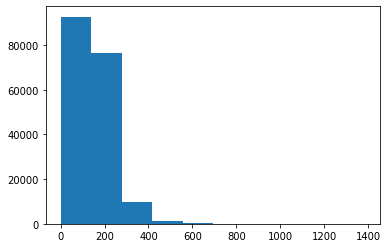

In [70]:
plt.hist(length_char, bins=10);

In [73]:
alphabet = string.ascii_lowercase + string.digits + string.punctuation 
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [74]:
char_vectorizer = TextVectorization(max_tokens=len(alphabet), # all keyboard characters
                                    output_sequence_length=int(np.percentile(length_char, 95)), # number of characters that cover 95% of lines
                                    standardize=None, 
                                    name="char_vectorizer")

char_vectorizer.adapt(train_char)

In [75]:
# explore character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Total characters: {len(char_vocab)}")
print(f"Most common characters: {char_vocab[:5]}")
print(f"Least common characters: {char_vocab[-5:]}")

Total characters: 57
Most common characters: ['', '[UNK]', 'e', 't', 'i']
Least common characters: ['|', '"', ']', '\\', '[']


In [76]:
char_embed = layers.Embedding(input_dim=57, 
                              output_dim=25, 
                              mask_zero=False, 
                              name="char_embed")

In [77]:
# sample line to test vectorizer and embedding
random_char = random.choice(train_char)
print(f"Line:\n {random_char}")
print(f"\nLength of line:\n {len(random_char.split())}")
vectorized_char = char_vectorizer([random_char])
print(f"\nAfter vectorization:\n {vectorized_char}")
embedded_char = char_embed(vectorized_char)
print(f"\nAfter embedding:\n {embedded_char}")
print(f"\nShape of line: {embedded_char.shape}")

Line:
 m u l t i v a r i a t e   c o x   m o d e l s   w e r e   u s e d   t o   a s s e s s   t h e   i n f l u e n c e   o f   t i m e - d e p e n d e n t   a p p r o p r i a t e   a n d   i n a p p r o p r i a t e   i c d   t h e r a p y   (   s h o c k   a n d   a n t i t a c h y c a r d i a   p a c i n g   )   a n d   r a n d o m i z e d   p r o g r a m m i n g   a r m   o n   a l l - c a u s e   m o r t a l i t y   .

Length of line:
 181

After vectorization:
 [[15 16 12  3  4 22  5  8  4  5  3  2 11  7 30 15  7 10  2 12  9 21  2  8
   2 16  9  2 10  3  7  5  9  9  2  9  9  3 13  2  4  6 17 12 16  2  6 11
   2  7 17  3  4 15  2 26 10  2 14  2  6 10  2  6  3  5 14 14  8  7 14  8
   4  5  3  2  5  6 10  4  6  5 14 14  8  7 14  8  4  5  3  2  4 11 10  3
  13  2  8  5 14 20 28  9 13  7 11 29  5  6 10  5  6  3  4  3  5 11 13 20
  11  5  8 10  4  5 14  5 11  4  6 18 27  5  6 10  8  5  6 10  7 15  4 32
   2 10 14  8  7 18  8  5 15 15  4  6 18  5  8 15  7  6  5 12 12 26 11  5
  16  9  2

In [78]:
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="Conv1D_char_embedding")

model_3.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [79]:
model_3.summary()

Model: "Conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1425      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5)       

In [80]:
# create tensorflow datasets in prefetch batches
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_char, train_label_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_char, val_label_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [81]:
model_3_history = model_3.fit(train_char_dataset, 
                              steps_per_epoch=int(0.1*len(train_char_dataset)), 
                              epochs=3,
                              validation_data=val_char_dataset, 
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 7s 10ms/step - loss: 1.1714 - accuracy: 0.5384 - val_loss: 0.9519 - val_accuracy: 0.6356
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.9035 - accuracy: 0.6418 - val_loss: 0.8438 - val_accuracy: 0.6795
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.8263 - accuracy: 0.6759 - val_loss: 0.7766 - val_accuracy: 0.7104


In [82]:
# evaluate on full validation dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 5ms/step - loss: 0.7907 - accuracy: 0.6942


[0.7906517386436462, 0.6941943764686584]

In [83]:
# prediction probablities of each class label
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.1830931 , 0.5358389 , 0.04362286, 0.21833019, 0.01911491],
       [0.16714428, 0.55654734, 0.04407925, 0.13993548, 0.09229366],
       [0.114168  , 0.47402087, 0.10482121, 0.2363408 , 0.07064911],
       ...,
       [0.00441056, 0.0050773 , 0.0452645 , 0.00520475, 0.94004285],
       [0.01559152, 0.09421592, 0.18314663, 0.01262393, 0.694422  ],
       [0.5380975 , 0.2217786 , 0.10484037, 0.11621456, 0.01906895]],
      dtype=float32)

In [84]:
# convert to prediction of each class label 
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 4, 0])>

In [85]:
# model_3 results
model_3_result = score(val_label_encode, model_3_preds)
model_3_result

{'accuracy': 0.6941943598570105,
 'f1': 0.6832451590745561,
 'precision': 0.6926593215377223,
 'recall': 0.6941943598570105}

# Model_4 Token + Character Embedding

In [86]:
# token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs) 
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# character inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# concatenate token and character inputs 
token_char_concat = layers.Concatenate(name="token_char_concat")([token_model.output, char_model.output])

# dropout layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5, activation="softmax")(final_dropout)

model_4 = tf.keras.Model([token_model.input, char_model.input], output_layer, name="Token_char_embedding")

model_4.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [87]:
model_4.summary()

Model: "Token_char_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs

In [88]:
# create prefetched batches
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_lines, train_char))
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_label_one_hot) 
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels)) # combine token and character data
train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_token_char_data = tf.data.Dataset.from_tensor_slices((val_lines, val_char))
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_label_one_hot)
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data, val_token_char_labels)) # combine token and character data
val_token_char_dataset = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_token_char_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [89]:
model_4_history = model_4.fit(train_token_char_dataset, 
                              steps_per_epoch=int(0.1*len(train_token_char_dataset)), 
                              epochs=3, 
                              validation_data=val_token_char_dataset, 
                              validation_steps=int(0.1*len(val_token_char_dataset)))

Epoch 1/3
562/562 [==============================] - 74s 118ms/step - loss: 0.9631 - accuracy: 0.6176 - val_loss: 0.7880 - val_accuracy: 0.6998
Epoch 2/3
562/562 [==============================] - 65s 115ms/step - loss: 0.7949 - accuracy: 0.6935 - val_loss: 0.7198 - val_accuracy: 0.7254
Epoch 3/3
562/562 [==============================] - 65s 115ms/step - loss: 0.7753 - accuracy: 0.7010 - val_loss: 0.6962 - val_accuracy: 0.7387


In [90]:
# evaluate on full validation data
model_4.evaluate(val_token_char_dataset)

945/945 [==============================] - 47s 50ms/step - loss: 0.6959 - accuracy: 0.7356


[0.6959120035171509, 0.7356348633766174]

In [91]:
# prediction probablitlies of each class label 
model_4_pred_probs = model_4.predict(val_token_char_dataset)
model_4_pred_probs

array([[3.55880886e-01, 4.23071355e-01, 4.27442184e-03, 2.07002193e-01,
        9.77105461e-03],
       [2.73606956e-01, 5.94201684e-01, 2.19568610e-03, 1.28102198e-01,
        1.89346063e-03],
       [2.55411148e-01, 1.18250325e-01, 4.65661399e-02, 5.55436909e-01,
        2.43354701e-02],
       ...,
       [9.13243217e-04, 2.68997787e-03, 6.21650331e-02, 1.09571105e-04,
        9.34122205e-01],
       [4.88446001e-03, 1.43605536e-02, 1.47636771e-01, 8.11302802e-04,
        8.32306981e-01],
       [3.10436606e-01, 3.96501213e-01, 2.18342885e-01, 3.66991237e-02,
        3.80201787e-02]], dtype=float32)

In [92]:
# convert to prediction of each class label
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [93]:
# model_4 results
model_4_result = score(val_label_encode, model_4_preds)
model_4_result

{'accuracy': 0.7356348470806302,
 'f1': 0.7331936183768214,
 'precision': 0.7393104971002874,
 'recall': 0.7356348470806302}

# Model_5 Token + Character + Positional Embedding

In [94]:
train_df.head(10)

,label,line,index,total_lines_in_abstract
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [95]:
# frequency of each index (position of line within abstract)
train_df["index"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: index, dtype: int64

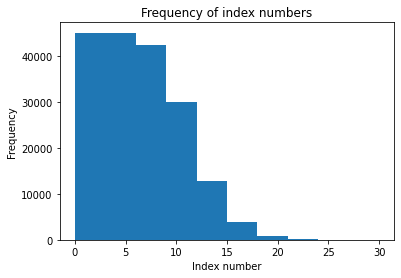

In [96]:
train_df["index"].plot.hist()
plt.title("Frequency of index numbers")
plt.xlabel("Index number");

In [98]:
# what index covers 95% of all lines
np.percentile(train_df["index"], 95)

13.0

In [99]:
# one hot encode labels
train_index_one_hot = tf.one_hot(train_df["index"].to_numpy(), depth=13)
val_index_one_hot = tf.one_hot(val_df["index"].to_numpy(), depth=13)
test_index_one_hot = tf.one_hot(test_df["index"].to_numpy(), depth=13)

train_index_one_hot[:20]

<tf.Tensor: shape=(20, 13), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.,

In [100]:
# frequency of total length of abstract 
train_df["total_lines_in_abstract"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines_in_abstract, dtype: int64

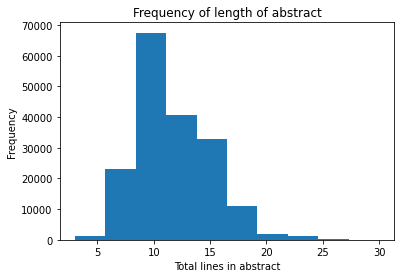

In [101]:
train_df["total_lines_in_abstract"].plot.hist()
plt.title("Frequency of length of abstract")
plt.xlabel("Total lines in abstract");

In [102]:
# how many lines cover 95% of all abstracts
np.percentile(train_df["total_lines_in_abstract"], 95)

18.0

In [103]:
# one hot encode total lines
train_total_lines_one_hot = tf.one_hot(train_df["total_lines_in_abstract"].to_numpy(), depth=18)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines_in_abstract"].to_numpy(), depth=18)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines_in_abstract"].to_numpy(), depth=18)

train_total_lines_one_hot

<tf.Tensor: shape=(180040, 18), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [104]:
# token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# character inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# positional inputs
index_inputs = layers.Input(shape=(13,), dtype=tf.float32, name="index_inputs")
x = layers.Dense(32, activation="relu")(index_inputs)
index_model = tf.keras.Model(index_inputs, x)

# total lines inputs
total_lines_inputs = layers.Input(shape=(18,), dtype=tf.float32, name="total_lines_inputs")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, y)

# concatenate token and character inputs
double_embedding = layers.Concatenate(name="token_char_embedding")([token_model.output, 
                                                                    char_model.output])

z = layers.Dense(256, activation="relu")(double_embedding)
z = layers.Dropout(0.5)(z)

# concatenate (token and character inputs) and positional inputs
triple_embedding = layers.Concatenate(name="token_char_position_embedding")([index_model.output, 
                                                                             total_lines_model.output, 
                                                                             z])

output_layer = layers.Dense(5, activation="softmax")(triple_embedding)

model_5 = tf.keras.Model([index_model.inputs, 
                          total_lines_model.inputs, 
                          token_model.inputs, 
                          char_model.inputs], 
                          output_layer, 
                          name="token_char_positional_embedding")

model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), 
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["accuracy"])

In [105]:
model_5.summary()

Model: "token_char_positional_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

In [106]:
# create prefetched batches
train_token_char_pos_data = tf.data.Dataset.from_tensor_slices((train_index_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_lines,
                                                                train_char))
train_token_char_pos_labels = tf.data.Dataset.from_tensor_slices(train_label_one_hot)
train_token_char_pos_dataset = tf.data.Dataset.zip((train_token_char_pos_data, train_token_char_pos_labels))
train_token_char_pos_dataset = train_token_char_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_token_char_pos_data = tf.data.Dataset.from_tensor_slices((val_index_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_lines,
                                                              val_char))
val_token_char_pos_labels = tf.data.Dataset.from_tensor_slices(val_label_one_hot)
val_token_char_pos_dataset = tf.data.Dataset.zip((val_token_char_pos_data, val_token_char_pos_labels))
val_token_char_pos_dataset = val_token_char_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_token_char_pos_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [107]:
model_5_history = model_5.fit(train_token_char_pos_dataset, 
                              steps_per_epoch=int(0.1*len(train_token_char_pos_dataset)),
                              epochs=3, 
                              validation_data=val_token_char_pos_dataset,
                              validation_steps=int(0.1*len(val_token_char_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 71s 117ms/step - loss: 1.1012 - accuracy: 0.7231 - val_loss: 0.9843 - val_accuracy: 0.8009
Epoch 2/3
562/562 [==============================] - 65s 115ms/step - loss: 0.9684 - accuracy: 0.8147 - val_loss: 0.9617 - val_accuracy: 0.8182
Epoch 3/3
562/562 [==============================] - 65s 115ms/step - loss: 0.9510 - accuracy: 0.8231 - val_loss: 0.9400 - val_accuracy: 0.8305


In [108]:
# evaluate on full validation data
model_5.evaluate(val_token_char_pos_dataset)

945/945 [==============================] - 48s 51ms/step - loss: 0.9341 - accuracy: 0.8350


[0.9341189861297607, 0.8350324630737305]

In [109]:
# prediction probablities of each class label
model_5_pred_probs = model_5.predict(val_token_char_pos_dataset)
model_5_pred_probs

array([[0.49940473, 0.09725714, 0.01103465, 0.37110075, 0.02120274],
       [0.55691224, 0.1002305 , 0.03619374, 0.2948448 , 0.01181869],
       [0.2987765 , 0.11860488, 0.14360268, 0.37765676, 0.06135919],
       ...,
       [0.02847239, 0.07655907, 0.03583962, 0.02514513, 0.83398384],
       [0.02108296, 0.20428333, 0.07270397, 0.0221792 , 0.67975056],
       [0.26674917, 0.5071113 , 0.12285414, 0.05676163, 0.04652383]],
      dtype=float32)

In [110]:
# convert to prediction of each class label
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [111]:
# model_5 results
model_5_result = score(val_label_encode, model_5_preds)
model_5_result

{'accuracy': 0.835032437442076,
 'f1': 0.8342459168153824,
 'precision': 0.8345200724420917,
 'recall': 0.835032437442076}

In [113]:
# create dataframe of all results for comparison
all_results = pd.DataFrame({"0 - Baseline": model_0_result, 
                            "1 - Conv1D token embedding": model_1_result, 
                            "2 - Universal Sentence Encoder" : model_2_result,
                            "3 - Conv1D char embedding": model_3_result,
                            "4 - Token + Char embedding": model_4_result,
                            "5 - Token + Char + Pos embedding": model_5_result})

all_results

,0 - Baseline,1 - Conv1D token embedding,2 - Universal Sentence Encoder,3 - Conv1D char embedding,4 - Token + Char embedding,5 - Token + Char + Pos embedding
accuracy,0.721832,0.787435,0.713326,0.694194,0.735635,0.835032
precision,0.718647,0.783874,0.713576,0.692659,0.739310,0.834520
recall,0.721832,0.787435,0.713326,0.694194,0.735635,0.835032
f1,0.698925,0.784871,0.710308,0.683245,0.733194,0.834246


# Evaluate test dataset on best performing model

In [114]:
# create test prefetched batches 
test_token_char_pos_data = tf.data.Dataset.from_tensor_slices((test_index_one_hot, 
                                                               test_total_lines_one_hot,
                                                               test_lines,
                                                               test_char))
test_token_char_pos_labels = tf.data.Dataset.from_tensor_slices(test_label_one_hot)
test_token_char_pos_dataset = tf.data.Dataset.zip((test_token_char_pos_data, test_token_char_pos_labels))
test_token_char_pos_dataset = test_token_char_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_token_char_pos_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [115]:
# evaluate on full test dataset
model_5.evaluate(test_token_char_pos_dataset)

942/942 [==============================] - 52s 56ms/step - loss: 0.9432 - accuracy: 0.8309


[0.9432023167610168, 0.8308942914009094]

In [116]:
# prediction probablities of each class label
model_5_test_pred_probs = model_5.predict(test_token_char_pos_dataset)
model_5_test_pred_probs

array([[0.34930006, 0.08272982, 0.03238047, 0.4886801 , 0.04690964],
       [0.37762308, 0.07394469, 0.12097776, 0.39533353, 0.03212099],
       [0.06411876, 0.02050141, 0.7976895 , 0.0866501 , 0.0310402 ],
       ...,
       [0.07132749, 0.11939862, 0.06156643, 0.04880184, 0.69890565],
       [0.06246624, 0.12279023, 0.05874826, 0.0424692 , 0.713526  ],
       [0.06233711, 0.68556666, 0.10960615, 0.03381302, 0.10867707]],
      dtype=float32)

In [117]:
# convert to prediction of each class label
model_5_test_preds = tf.argmax(model_5_test_pred_probs, axis=1)
model_5_test_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 3, 2, ..., 4, 4, 1])>

In [118]:
# model_5 test results
model_5_test_result = score(test_label_encode, model_5_test_preds)
model_5_test_result

{'accuracy': 0.8308943089430895,
 'f1': 0.83000977297344,
 'precision': 0.8300513743977844,
 'recall': 0.8308943089430895}